In [26]:
#use kernel named top2vec310new
import pandas as pd
import numpy as np
import ast
import torch
import top2vec
from top2vec import Top2Vec
from sentence_transformers import SentenceTransformer
from top2vec import Top2Vec
from sklearn.cluster import KMeans

In [16]:
df = pd.read_csv("/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1111/merged data/vcpatent_2000_2021.csv") #enter the path for patent data saved in appenddata_code.ipynb
df.info()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1111/merged data/vcpatent_2000_2021.csv'

In [ ]:
dfnew = df[(df['grant_year'] >= 2000) & (df['grant_year'] <= 2021)] #keep patent between 2000 and 2021
dfnew = df[df['cpc_sections'].str.contains('C', na=False)] #keep patent which contains section C
dfnew.shape #check the shape (31,4889,23)

In [5]:
before = len(dfnew)

df_clean = dfnew.dropna(subset=["patent_abstract"])
df_clean = df_clean[df_clean["patent_abstract"].str.strip() != ""]  # move NA value of abstarct

after = len(df_clean)

removed = before - after

print(f"Number of original sample: {before}")
print(f"Number of sample after deleting: {after}")
print(f"Number of deleted: {removed}")

output_path = "/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1202/vc0021_C.csv" #preserved clean version
df_clean.to_csv(output_path, index=False) 

Number of original sample: 314889
Number of sample after deleting: 314840
Number of deleted: 49


In [61]:
dftest = pd.read_csv("/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1202/vc0021_C.csv")
documents = dftest["patent_abstract"].astype(str).tolist()

##Check the best K
In the first block, we can get a approximate range of k. After we make sure the range, we can find the best k in that range which we do in the second block

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

Ks = [50, 100, 150, 200, 250, 300] 
sil_scores = [] # silhouette score is used to determine the K-mean is good or not, higher score is better
sse_scores = []

for k in Ks:
    print(f"Processing KMeans (K={k}) ...")
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(topic_vectors)
    
    # ① Silhouette Score
    sil = silhouette_score(topic_vectors, labels)
    sil_scores.append(sil)
    
    # ② 模型的 SSE（inertia）
    sse = kmeans.inertia_
    sse_scores.append(sse)

    print(f"K={k}: Silhouette={sil:.4f}, SSE={sse:.0f}")

print("\ndone！")


正在运行 KMeans (K=50) ...
K=50: Silhouette=0.0406, SSE=1451
正在运行 KMeans (K=100) ...
K=100: Silhouette=0.0410, SSE=1330
正在运行 KMeans (K=150) ...
K=150: Silhouette=0.0466, SSE=1247
正在运行 KMeans (K=200) ...
K=200: Silhouette=0.0470, SSE=1184
正在运行 KMeans (K=250) ...
K=250: Silhouette=0.0427, SSE=1137
正在运行 KMeans (K=300) ...
K=300: Silhouette=0.0438, SSE=1091

比较完毕！


In [25]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

sil_scores = []
sse_scores = []
Ks = list(range(150, 251))  # 150~250

print("Begin K = 150 到 250（1）...\n")

for k in Ks:
    print(f"Processing KMeans (K={k}) ...")
    
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(topic_vectors)

    # ① Silhouette Score
    sil = silhouette_score(topic_vectors, labels)
    sil_scores.append(sil)

    # ② SSE
    sse = kmeans.inertia_
    sse_scores.append(sse)

    print(f"K={k}: Silhouette={sil:.4f}, SSE={sse:.0f}")

print("\ndone\n")

best_index = np.argmax(sil_scores)
best_K = Ks[best_index]
best_sil = sil_scores[best_index]
best_sse = sse_scores[best_index]

print("========== Best K ==========")
print(f"BestK= {best_K}")
print(f"Best Silhouette Score = {best_sil:.4f}")
print(f"SSE = {best_sse:.0f}")
print("================================")


Begin K = 150 到 250（1）...

Processing KMeans (K=150) ...
K=150: Silhouette=0.0466, SSE=1247
Processing KMeans (K=151) ...
K=151: Silhouette=0.0458, SSE=1247
Processing KMeans (K=152) ...
K=152: Silhouette=0.0463, SSE=1245
Processing KMeans (K=153) ...
K=153: Silhouette=0.0460, SSE=1244
Processing KMeans (K=154) ...
K=154: Silhouette=0.0462, SSE=1242
Processing KMeans (K=155) ...
K=155: Silhouette=0.0471, SSE=1239
Processing KMeans (K=156) ...
K=156: Silhouette=0.0472, SSE=1238
Processing KMeans (K=157) ...
K=157: Silhouette=0.0469, SSE=1237
Processing KMeans (K=158) ...
K=158: Silhouette=0.0482, SSE=1235
Processing KMeans (K=159) ...
K=159: Silhouette=0.0480, SSE=1234
Processing KMeans (K=160) ...
K=160: Silhouette=0.0482, SSE=1232
Processing KMeans (K=161) ...
K=161: Silhouette=0.0482, SSE=1231
Processing KMeans (K=162) ...
K=162: Silhouette=0.0474, SSE=1230
Processing KMeans (K=163) ...
K=163: Silhouette=0.0471, SSE=1229
Processing KMeans (K=164) ...
K=164: Silhouette=0.0472, SSE=122

In [ ]:
#Top2vec
model = Top2Vec(
    documents,
    embedding_model='all-MiniLM-L6-v2',
    speed='deep-learn',
    workers=4
)
K = 5
doc_ids = list(range(len(documents)))

topics, scores, topic_words, word_scores = model.get_documents_topics(
    doc_ids, num_topics=K
)

dftest["topK_topics"] = topics.tolist()
dftest["topK_scores"] = scores.tolist()

topic_vectors = model.topic_vectors      #get topic vectors      
topic_nums = list(range(model.topic_vectors.shape[0]))

print("Original number of topics:", len(topic_vectors))

n_super_topics = 171 #K-means for cluster

kmeans = KMeans(n_clusters=n_super_topics, random_state=42)
super_topic_labels = kmeans.fit_predict(topic_vectors)
print("Super topics created:", n_super_topics)

topic_to_super = dict(zip(topic_nums, super_topic_labels))

super_topics_for_docs = [] #get topic 
main_super_topic = []   
for topic_list in topics:
    super_list = [topic_to_super[t] for t in topic_list]
    super_topics_for_docs.append(super_list)
    main_super_topic.append(super_list[0])   

dftest["super_topics"] = super_topics_for_docs
dftest["main_super_topic"] = main_super_topic

output_path = "/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1202/vc_c_top2vec_results_kmeans_V2.csv"
dftest.to_csv(output_path, index=False)

print(f"Done! Results saved to {output_path}")


2025-12-22 21:24:02,771 - top2vec - INFO - Pre-processing documents for training
/Users/liusiyi/anaconda3/envs/top2vec310new/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2025-12-22 21:24:38,752 - top2vec - INFO - Downloading all-MiniLM-L6-v2 model
2025-12-22 21:24:42,164 - top2vec - INFO - Creating joint document/word embedding
2025-12-22 22:00:46,439 - top2vec - INFO - Creating lower dimension embedding of documents
2025-12-22 22:07:20,133 - top2vec - INFO - Finding dense areas of documents
/Users/liusiyi/anaconda3/envs/top2vec310new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/liusiyi/anaconda3/envs/top2vec310new/lib/python3.10/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' wa

Original number of topics: 3155


/Users/liusiyi/anaconda3/envs/top2vec310new/lib/python3.10/site-packages/threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


Super topics created: 171
Done! Results saved to /Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1202/vc_c_top2vec_results_kmeans_V2.csv


In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# ① get document vectors
doc_vectors = model.document_vectors

# get super topic cluster centers (KMeans centers)
centers = kmeans.cluster_centers_   # shape (200, 768)

# list for 5 similarities
similarity_list = []

for i, row in dftest.iterrows():
    doc_vec = doc_vectors[i].reshape(1, -1)
    super_tops = row["super_topics"][:5]  # 前 5 个 super topic
    
    sims = []
    for st in super_tops:
        center_vec = centers[st].reshape(1, -1)
        sim = cosine_similarity(doc_vec, center_vec)[0][0]
        sims.append(sim)
    
    similarity_list.append(sims)

dftest["top5_similarities"] = similarity_list
dftest[["sim1", "sim2", "sim3", "sim4", "sim5"]] = pd.DataFrame(dftest["top5_similarities"].tolist())

output_path = "/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/1202/vc_c_top2vec_results_kmeans_V2.csv"
dftest.to_csv(output_path, index=False)

In [ ]:
#descriptive statistics of the similarity score (the cosine similarity to the super topic got from top2vec )
sim_cols = ["sim1", "sim2", "sim3", "sim4", "sim5"]

sim_stats = pd.DataFrame({
    "mean": dftest[sim_cols].mean(),
    "min":  dftest[sim_cols].min(),
    "max":  dftest[sim_cols].max()
})

print(sim_stats)

          mean       min       max
sim1  0.612747  0.045642  0.962659
sim2  0.601981  0.009379  0.962659
sim3  0.596184 -0.057813  0.962659
sim4  0.591256 -0.023368  0.925547
sim5  0.586550 -0.019397  0.925547


In [ ]:
#calculate the most frequent topic each year for the entire sample
from collections import Counter
year_top_topic = {}

years = dftest["grant_year"].unique()

for y in years:
    df_year = dftest[dftest["grant_year"] == y]

    topics_flat = []
    for lst in df_year["super_topics"]:
        topics_flat.extend(lst)   #extend the list

    # count frequency
    counter = Counter(topics_flat)

    # find the most common topic
    most_common_topic, most_common_count = counter.most_common(1)[0]

    year_top_topic[y] = {
        "top_topic": most_common_topic,
        "count": most_common_count,
        "all_counts": counter
    }

# displot outcome
for y, info in sorted(year_top_topic.items()):
    print(f"Year {y}: Most frequent topic = {info['top_topic']} (count={info['count']})")


Year 2000.0: Most frequent topic = 62 (count=2270)
Year 2001.0: Most frequent topic = 62 (count=2627)
Year 2002.0: Most frequent topic = 62 (count=2568)
Year 2003.0: Most frequent topic = 62 (count=1987)
Year 2004.0: Most frequent topic = 62 (count=1902)
Year 2005.0: Most frequent topic = 129 (count=1698)
Year 2006.0: Most frequent topic = 62 (count=2401)
Year 2007.0: Most frequent topic = 62 (count=2713)
Year 2008.0: Most frequent topic = 62 (count=2187)
Year 2009.0: Most frequent topic = 129 (count=2188)
Year 2010.0: Most frequent topic = 129 (count=2315)
Year 2011.0: Most frequent topic = 129 (count=2209)
Year 2012.0: Most frequent topic = 129 (count=2322)
Year 2013.0: Most frequent topic = 129 (count=2682)
Year 2014.0: Most frequent topic = 129 (count=2527)
Year 2015.0: Most frequent topic = 129 (count=2414)
Year 2016.0: Most frequent topic = 129 (count=2393)
Year 2017.0: Most frequent topic = 129 (count=2642)
Year 2018.0: Most frequent topic = 129 (count=2281)
Year 2019.0: Most fr

In [ ]:
#calculate the most frequent topic each year for the public patents
import pandas as pd
from collections import Counter

df_sub = dftest[dftest["univ_hospital_gov"] == 1].copy()

year_top5_stats = {}

for grant_year, group in df_sub.groupby("grant_year"):

    all_topics = []
    for lst in group["super_topics"]:
        all_topics.extend(lst[:5])

    counter = Counter(all_topics)
    top_topic, top_count = counter.most_common(1)[0]

    year_top5_stats[grant_year] = {
        "top_topic": top_topic,
        "count": top_count,
        "full_distribution": dict(counter)
    }

result = pd.DataFrame([
    {"grant_year": y, "top_topic": v["top_topic"], "count": v["count"]}
    for y, v in year_top5_stats.items()
]).sort_values("grant_year")

print(result)

    grant_year  top_topic  count
0       2000.0         62    584
1       2001.0         62    694
2       2002.0         62    518
3       2003.0         62    475
4       2004.0         62    477
5       2005.0         62    324
6       2006.0         62    506
7       2007.0         62    362
8       2008.0         62    360
9       2009.0         62    369
10      2010.0         62    375
11      2011.0         62    318
12      2012.0         50    336
13      2013.0         50    362
14      2014.0         50    435
15      2015.0         50    395
16      2016.0         50    517
17      2017.0         26    490
18      2018.0         26    570
19      2019.0         26    571
20      2020.0         26    601
21      2021.0         17    676


In [ ]:

from collections import Counter
n_super_topics = 200

super_topic_keywords = {}

for st in range(n_super_topics):
    indices = [i for i, lbl in enumerate(super_topic_labels) if lbl == st]
    
    all_words = []
    for idx in indices:
        words = model.topic_words[idx][:20].tolist()   
        all_words.extend(words)

    super_topic_keywords[st] = Counter(all_words)


In [73]:
# create word cloud for top2vec 

from wordcloud import WordCloud
import matplotlib.pyplot as plt

def plot_super_topic_wordcloud(st_id, save=False):
    word_freq = super_topic_keywords[st_id]

    wc = WordCloud(
        width=600,
        height=400,
        background_color='white',
        colormap='viridis'
    ).generate_from_frequencies(word_freq)

    plt.figure(figsize=(6, 4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Super Topic {st_id} Word Cloud", fontsize=20)
    
    if save:
        wc.to_file(f"super_topic_{st_id}.png")
        print(f"已保存: super_topic_{st_id}.png")

    plt.show()




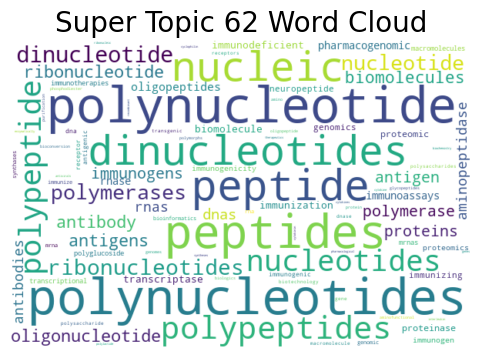

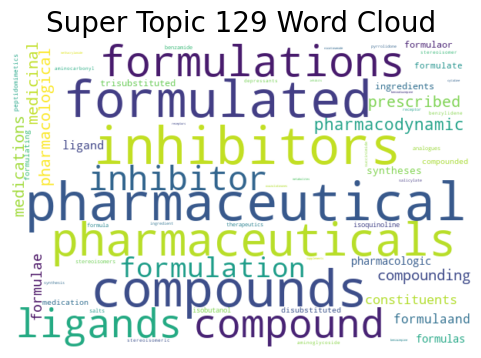

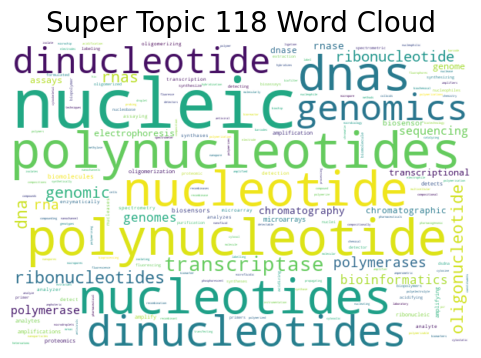

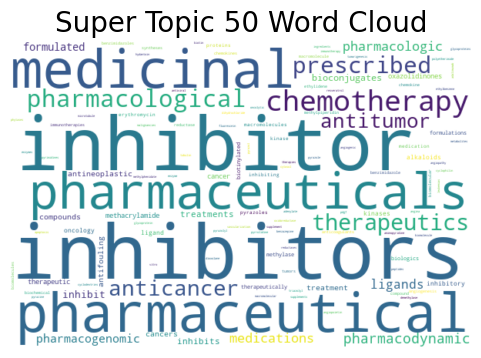

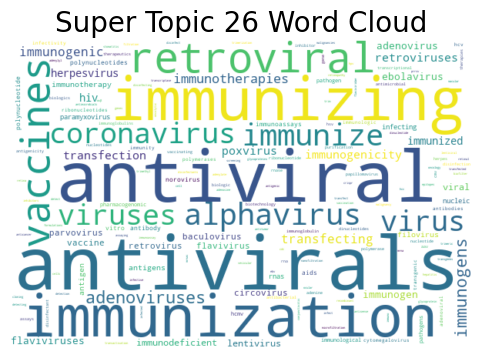

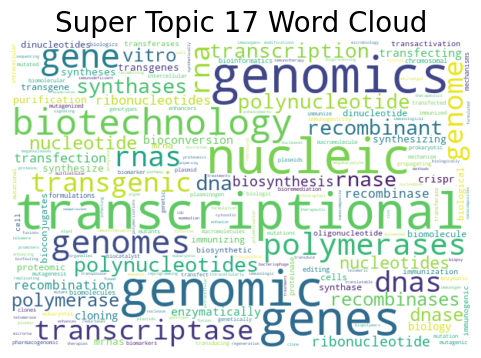

In [74]:
plot_super_topic_wordcloud(62)
plot_super_topic_wordcloud(129)
plot_super_topic_wordcloud(118)
plot_super_topic_wordcloud(50)
plot_super_topic_wordcloud(26)
plot_super_topic_wordcloud(17)



In [20]:
import pandas as pd

dftest = pd.read_csv("vc_c_top2vec_results_kmeans_V2.csv")
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314840 entries, 0 to 314839
Data columns (total 38 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   patent_id                         314840 non-null  int64  
 1   founding_year                     222220 non-null  float64
 2   founding_score                    222220 non-null  float64
 3   VC_backed_assignee                314840 non-null  float64
 4   VC_score                          53033 non-null   float64
 5   initassignee_id                   314840 non-null  object 
 6   initassignee_organization         314840 non-null  object 
 7   same_as20220630pv                 314840 non-null  int64  
 8   assignee_organization_20220630pv  314838 non-null  object 
 9   assignee_id_20220630pv            314840 non-null  object 
 10  initassignee_idxwalk20220630pv    296480 non-null  object 
 11  Found in OC                       314840 non-null  f

In [76]:
##create mean/variance/df/min/max for each patent based on similarity score
sim_cols = ['sim1', 'sim2', 'sim3', 'sim4', 'sim5']
dftest['sim_mean'] = dftest[sim_cols].mean(axis=1)
dftest['sim_variance'] = dftest[sim_cols].var(axis=1)
dftest['sim_std'] = dftest[sim_cols].std(axis=1)
dftest['sim_min'] = dftest[sim_cols].min(axis=1)
dftest['sim_max'] = dftest[sim_cols].max(axis=1)
dftest.head()

dftest.to_csv(output_path, index=False) 

In [77]:
dftest[['sim_mean', 'sim_variance', 'sim_std', 'sim_min', 'sim_max']].describe()

,sim_mean,sim_variance,sim_std,sim_min,sim_max
count,314840.000000,314840.000000,314840.000000,314840.000000,314840.000000
mean,0.597743,0.002540,0.041221,0.538267,0.630402
std,0.100654,0.003344,0.029001,0.120166,0.092376
min,0.067506,0.000000,0.000000,-0.057813,0.102864
25%,0.532322,0.000410,0.020255,0.459348,0.570797
50%,0.598855,0.001490,0.038598,0.537061,0.632388
75%,0.663520,0.003434,0.058601,0.614823,0.691387
max,0.925547,0.063265,0.251526,0.925547,0.962659


In [ ]:
dftest["topK_scores"] = dftest["topK_scores"].apply(ast.literal_eval) #conevrt top)_scores to list and then we can expand them into 5 different columns for mean/variance
topk_df = pd.DataFrame(
    dftest["topK_scores"].tolist(),
    columns=[f"topK_{i+1}" for i in range(5)]
)

dftest = pd.concat([dftest, topk_df], axis=1)
dftest.info()#check the current dataset

In [ ]:
#calculate the mean/variance/std for k scores
topk_cols = ["topK_1", "topK_2", "topK_3", "topK_4", "topK_5"]
dftest["topK_mean"] = dftest[topk_cols].mean(axis=1)
dftest["topK_variance"] = dftest[topk_cols].var(axis=1, ddof=1)
dftest["topK_std"] = dftest[topk_cols].std(axis=1, ddof=1)

In [34]:
#distribution of bothe K scores and similarity scores (K clusters)
dftest["topK_variance"].describe()

count    3.148400e+05
mean     4.298816e-03
std      5.574390e-03
min      3.602147e-07
25%      7.496115e-04
50%      2.181271e-03
75%      5.595813e-03
max      6.720927e-02
Name: topK_variance, dtype: float64

In [35]:
dftest["sim_variance"].describe()

count    314840.000000
mean          0.002540
std           0.003344
min           0.000000
25%           0.000410
50%           0.001490
75%           0.003434
max           0.063265
Name: sim_variance, dtype: float64

In [37]:
output_path="/Users/liusiyi/Library/CloudStorage/OneDrive-IndianaUniversity/Research/patent/0127/data/0203withsimilaritysscore.csv"
dftest.to_csv(output_path, index=False) 